<a href="https://colab.research.google.com/github/Kryptera-K/BLK-CCI-Volatility-Flush-with-Senkou-Span-Strategy/blob/main/BLK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "BLK"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("BLK_clean.csv", index=False)
df

/tmp/ipython-input-3383964749.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,9.949152,10.472792,9.949152,10.435389,64600
2000-01-04,9.500316,9.949149,9.350704,9.949149,81900
2000-01-05,9.425512,9.425512,8.976678,9.425512,38100
2000-01-06,9.575125,9.724736,9.425513,9.425513,41200
2000-01-07,9.500316,9.724733,9.425510,9.500316,34700
...,...,...,...,...,...
2025-12-15,1082.160034,1098.849976,1078.500000,1095.430054,564700
2025-12-16,1068.140015,1083.189941,1063.890015,1081.359985,651500
2025-12-17,1065.000000,1083.750000,1064.640015,1072.800049,648100


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6

# -------------------------
# Indicator Functions
# -------------------------

def woodies_vegas_trade_down(df, period=WOODIE_FAST_PERIOD):
    df['CCI_main'] = calculate_woodie_cci(df, period)['CCI']
    return (df['CCI_main'] < -100) & (df['CCI_main'].shift(1) >= -100)


def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    """
    Calculate Commodity Channel Index (CCI).
    """
    df = df.copy()
    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    # SMA of TP
    df['SMA_TP'] = df['TP'].rolling(period).mean()
    # Mean Deviation
    df['MeanDev'] = df['TP'].rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    # CCI
    df['CCI'] = (df['TP'] - df['SMA_TP']) / (0.015 * df['MeanDev'])
    return df


def senkou_span_cross_bullish(df):
    df = calculate_ichimoku(df)
    return (df['senkou_span_a'].shift(1) < df['senkou_span_b'].shift(1)) & (df['senkou_span_a'] > df['senkou_span_b'])


def calculate_ichimoku(df, tenkan_period=ICHIMOKU_TENKAN_PERIOD, kijun_period=ICHIMOKU_KIJUN_PERIOD, senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD, displacement=ICHIMOKU_DISPLACEMENT):
    df = df.copy()

    # Lines
    df['tenkan_sen'] = (df['High'].rolling(tenkan_period).max() + df['Low'].rolling(tenkan_period).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(kijun_period).max() + df['Low'].rolling(kijun_period).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(displacement)
    df['senkou_span_b'] = ((df['High'].rolling(senkou_b_period).max() + df['Low'].rolling(senkou_b_period).min()) / 2).shift(displacement)
    df['chikou_span'] = df['Close'].shift(-displacement)

    return df



# -------------------------
# Entry conditions
# -------------------------

df["Woodies_Vegas_Trade_Down"] = woodies_vegas_trade_down(df)

# -------------------------
# Exit conditions
# -------------------------

df["Ichimoku_Senkou_Span_Cross_Bullish"] = senkou_span_cross_bullish(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'Woodies_Vegas_Trade_Down',
]
exit_conditions = [
    'Ichimoku_Senkou_Span_Cross_Bullish',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                         2000-01-03 00:00:00
End                           2025-12-19 00:00:00
Period                         6532 days 00:00:00
Start Value                              100000.0
End Value                         13356786.256175
Total Return [%]                     13256.786256
Benchmark Return [%]                  10124.34312
Max Gross Exposure [%]                      100.0
Total Fees Paid                     387662.608518
Max Drawdown [%]                        58.968296
Max Drawdown Duration           748 days 00:00:00
Total Trades                                   65
Total Closed Trades                            64
Total Open Trades                               1
Open Trade PnL                     1086854.393109
Win Rate [%]                                 75.0
Best Trade [%]                         136.774876
Worst Trade [%]                        -47.555946
Avg Winning Trade [%]                   16.283162
Avg Losing Trade [%]                    -9.217268


In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-12-19 00:00:00
Period                         6532 days 00:00:00
Start Value                              100000.0
End Value                         10224343.120442
Total Return [%]                      10124.34312
Benchmark Return [%]                  10124.34312
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        59.849305
Max Drawdown Duration           755 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    10124343.120442
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2304687993.py:13: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


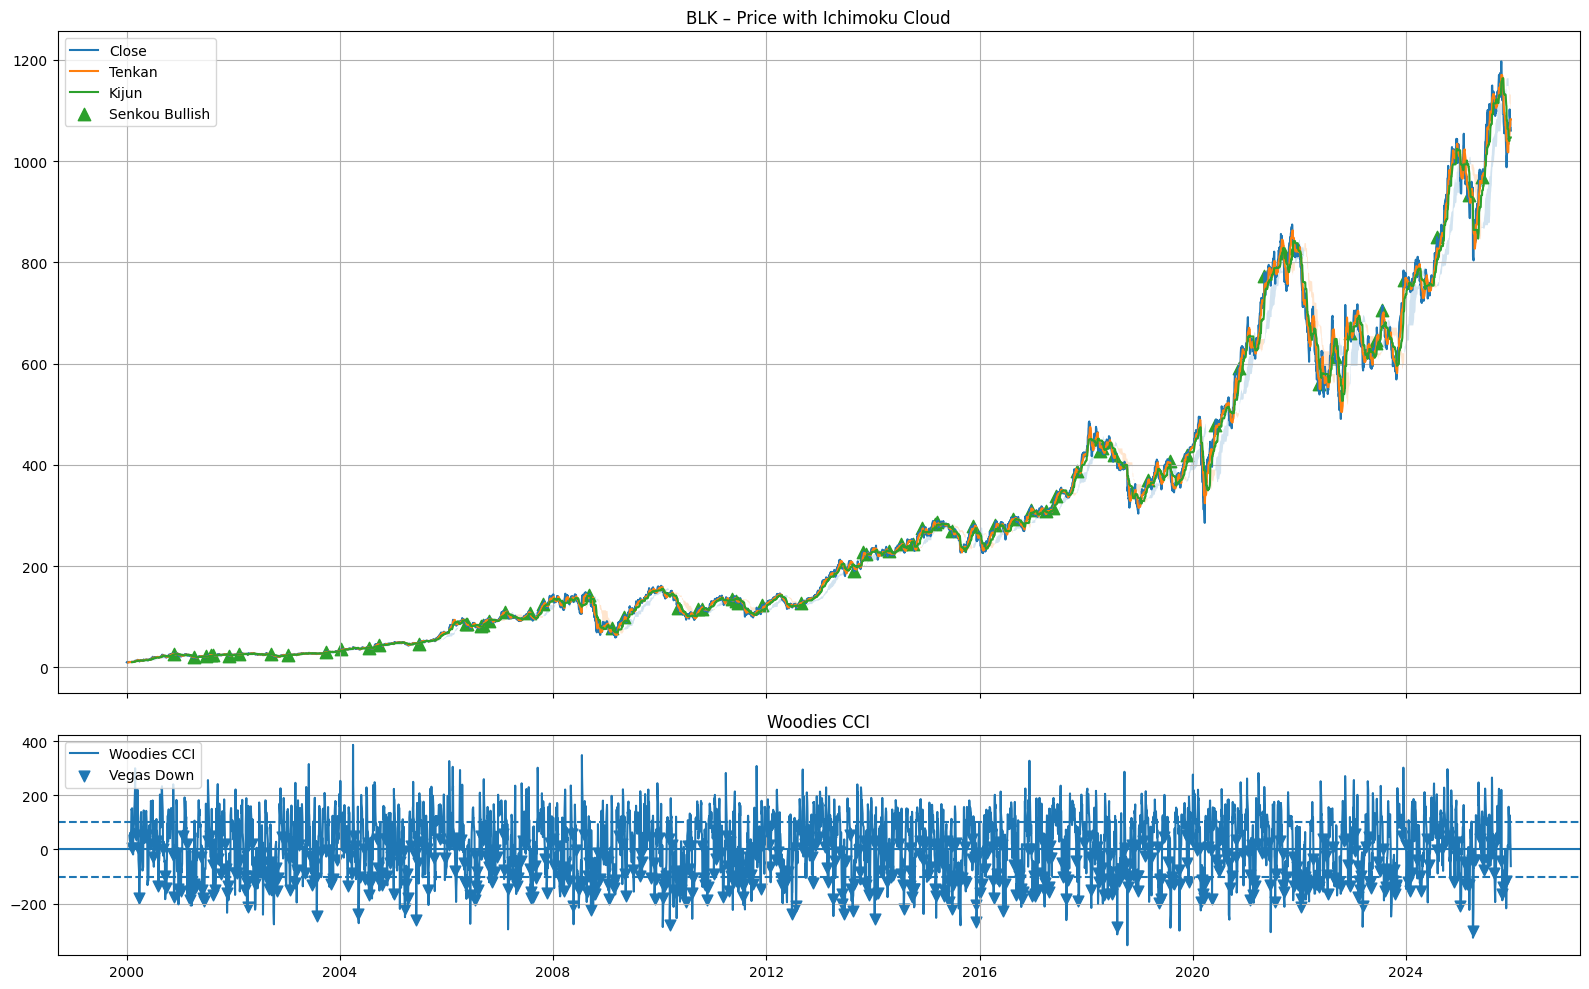

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------
symbol = "BLK"
start_date = "2000-01-01"
end_date = "2026-01-01"

df = yf.download(symbol, start=start_date, end=end_date, interval="1d", multi_level_index=False)
df = df.dropna()

# -------------------------
# Parameters
# -------------------------
ICHIMOKU_DISPLACEMENT = 26
ICHIMOKU_KIJUN_PERIOD = 26
ICHIMOKU_SENKOU_B_PERIOD = 52
ICHIMOKU_TENKAN_PERIOD = 9
WOODIE_CCI_PERIOD = 14
WOODIE_FAST_PERIOD = 6

# -------------------------
# Indicator Functions
# -------------------------
def calculate_woodie_cci(df, period=WOODIE_CCI_PERIOD):
    """
    Woodies Commodity Channel Index (CCI)
    """
    df = df.copy()
    tp = (df["High"] + df["Low"] + df["Close"]) / 3
    sma = tp.rolling(period).mean()
    mean_dev = tp.rolling(period).apply(
        lambda x: np.mean(np.abs(x - np.mean(x))), raw=True
    )
    df["CCI"] = (tp - sma) / (0.015 * mean_dev)
    return df


def woodies_vegas_trade_down(df, period=WOODIE_FAST_PERIOD):
    """
    Woodies Vegas Trade Down Signal
    """
    cci = calculate_woodie_cci(df, period)["CCI"]
    return (cci < -100) & (cci.shift(1) >= -100)


def calculate_ichimoku(
    df,
    tenkan_period=ICHIMOKU_TENKAN_PERIOD,
    kijun_period=ICHIMOKU_KIJUN_PERIOD,
    senkou_b_period=ICHIMOKU_SENKOU_B_PERIOD,
    displacement=ICHIMOKU_DISPLACEMENT,
):
    """
    Ichimoku Cloud
    """
    df = df.copy()
    df["tenkan_sen"] = (df["High"].rolling(tenkan_period).max() +
                        df["Low"].rolling(tenkan_period).min()) / 2

    df["kijun_sen"] = (df["High"].rolling(kijun_period).max() +
                       df["Low"].rolling(kijun_period).min()) / 2

    df["senkou_span_a"] = ((df["tenkan_sen"] + df["kijun_sen"]) / 2).shift(displacement)

    df["senkou_span_b"] = ((df["High"].rolling(senkou_b_period).max() +
                            df["Low"].rolling(senkou_b_period).min()) / 2).shift(displacement)

    df["chikou_span"] = df["Close"].shift(-displacement)
    return df


def senkou_span_cross_bullish(df):
    """
    Senkou Span A crosses above Senkou Span B
    """
    return (
        (df["senkou_span_a"].shift(1) < df["senkou_span_b"].shift(1))
        & (df["senkou_span_a"] > df["senkou_span_b"])
    )

# -------------------------
# Calculate Indicators
# -------------------------
df = calculate_ichimoku(df)
df = calculate_woodie_cci(df)

df["WOODIE_DOWN"] = woodies_vegas_trade_down(df)
df["SENKOU_BULL"] = senkou_span_cross_bullish(df)

# -------------------------
# Plot
# -------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(16, 10), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
)

# ===== PRICE + ICHIMOKU =====
ax1.plot(df.index, df["Close"], label="Close")
ax1.plot(df.index, df["tenkan_sen"], label="Tenkan")
ax1.plot(df.index, df["kijun_sen"], label="Kijun")

ax1.fill_between(
    df.index,
    df["senkou_span_a"],
    df["senkou_span_b"],
    where=df["senkou_span_a"] >= df["senkou_span_b"],
    alpha=0.2,
    interpolate=True,
)

ax1.fill_between(
    df.index,
    df["senkou_span_a"],
    df["senkou_span_b"],
    where=df["senkou_span_a"] < df["senkou_span_b"],
    alpha=0.2,
    interpolate=True,
)

# Senkou Bullish Cross
ax1.scatter(
    df.index[df["SENKOU_BULL"]],
    df["Close"][df["SENKOU_BULL"]],
    marker="^",
    s=80,
    label="Senkou Bullish",
)

ax1.set_title("BLK – Price with Ichimoku Cloud")
ax1.legend()
ax1.grid(True)

# ===== WOODIES CCI =====
ax2.plot(df.index, df["CCI"], label="Woodies CCI")
ax2.axhline(100, linestyle="--")
ax2.axhline(-100, linestyle="--")
ax2.axhline(0)

# Woodies Down Signal
ax2.scatter(
    df.index[df["WOODIE_DOWN"]],
    df["CCI"][df["WOODIE_DOWN"]],
    marker="v",
    s=60,
    label="Vegas Down",
)

ax2.set_title("Woodies CCI")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()
